## Adaptive Loss Weighing (Stop Guessing Lambda)

Successfully loaded 168 discharge cycles.
   Cycle  Capacity
0      2  1.856487
1      4  1.846327
2      6  1.835349
3      8  1.835263
4     10  1.834646


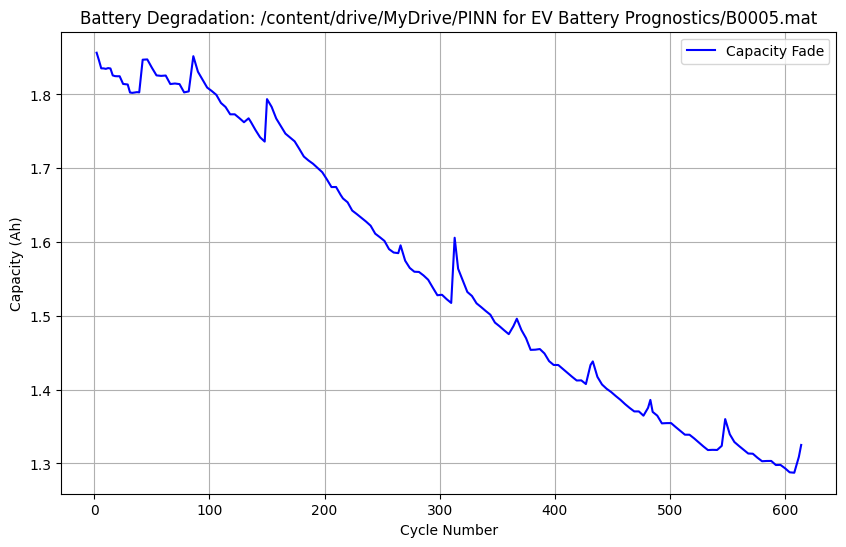

In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_nasa_data(mat_file_path):
    data = scipy.io.loadmat(mat_file_path)
    filename = mat_file_path.split('/')[-1].split('.')[0]
    batch = data[filename]
    cycles = batch[0][0]['cycle'][0]

    cycle_numbers = []
    capacities = []

    for i, cycle in enumerate(cycles):
        cycle_type = cycle['type'][0]

        if cycle_type == 'discharge':
            try:
                capacity = cycle['data'][0][0]['Capacity'][0][0]

                cycle_numbers.append(i + 1) # Cycle count
                capacities.append(capacity) # Capacity in Amp-hours (Ah)
            except:
                pass

    df = pd.DataFrame({
        'Cycle': cycle_numbers,
        'Capacity': capacities
    })

    return df

filename = '/content/drive/MyDrive/PINN for EV Battery Prognostics/B0005.mat'

try:
    df_battery = load_nasa_data(filename)

    print(f"Successfully loaded {len(df_battery)} discharge cycles.")
    print(df_battery.head())

    # --- PLOT TO VERIFY ---
    plt.figure(figsize=(10, 6))
    plt.plot(df_battery['Cycle'], df_battery['Capacity'], 'b-', label='Capacity Fade')
    plt.xlabel('Cycle Number')
    plt.ylabel('Capacity (Ah)')
    plt.title(f'Battery Degradation: {filename}')
    plt.grid(True)
    plt.legend()
    plt.show()

except FileNotFoundError:
    print(f"Error: Could not find {filename}. Please download the dataset and place it in this folder.")

In [2]:
df_battery.describe()

,Cycle,Capacity
count,168.000000,168.000000
mean,294.000000,1.572502
std,184.947314,0.190413
min,2.000000,1.287453
25%,133.000000,1.390021
50%,292.000000,1.557085
75%,454.000000,1.769163
max,614.000000,1.856487


In [3]:
import numpy as np
import tensorflow as tf

In [4]:
train_ratio=0.5
train_size=int(len(df_battery)*train_ratio)

In [5]:
# normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_array = scaler.fit_transform(df_battery[['Capacity', 'Cycle']])

df_battery_scaled = pd.DataFrame(
    scaled_array,
    columns=['Capacity', 'Cycle'],
    index=df_battery.index   # keeps original index
)

In [6]:
df_battery_scaled.describe()

,Capacity,Cycle
count,168.000000,168.000000
mean,0.500935,0.477124
std,0.334624,0.302201
min,0.000000,0.000000
25%,0.180250,0.214052
50%,0.473843,0.473856
75%,0.846539,0.738562
max,1.000000,1.000000


In [7]:
df_battery_scaled.head()

,Capacity,Cycle
0,1.000000,0.000000
1,0.982145,0.003268
2,0.962852,0.006536
3,0.962700,0.009804
4,0.961616,0.013072


In [8]:
train_data=df_battery_scaled.iloc[:train_size]
test_data=df_battery_scaled.iloc[train_size:]

In [9]:
t_train_np=train_data['Cycle'].values.reshape(-1,1)
t_test_np=test_data['Cycle'].values.reshape(-1,1)

c_train_np=train_data['Capacity'].values.reshape(-1,1)
c_test_np=test_data['Capacity'].values.reshape(-1,1)

In [10]:
# converting to tensorflow tensors to feed to nn
t_train_tf=tf.convert_to_tensor(t_train_np, dtype=tf.float32)
t_test_tf=tf.convert_to_tensor(t_test_np, dtype=tf.float32)

c_train_tf=tf.convert_to_tensor(c_train_np, dtype=tf.float32)
c_test_tf=tf.convert_to_tensor(c_test_np, dtype=tf.float32)

In [11]:
print(f"Data Prepared for TensorFlow:")
print(f"Training Samples: {t_train_tf.shape[0]} (First {train_ratio*100}% of life)")
print(f"Testing Samples:  {t_test_tf.shape[0]} (Remaining {(1-train_ratio)*100}%)")

Data Prepared for TensorFlow:
Training Samples: 84 (First 50.0% of life)
Testing Samples:  84 (Remaining 50.0%)


### Using Square Root Model

In [12]:
class PINNModel(tf.keras.Model):
  def __init__(self):
    super(PINNModel, self).__init__()

    #building hidden layers
    self.hidden1=tf.keras.layers.Dense(32,activation='tanh')
    self.hidden2=tf.keras.layers.Dense(32,activation='tanh')
    self.hidden3=tf.keras.layers.Dense(32,activation='tanh')

    #buidling output layer
    self.out=tf.keras.layers.Dense(1,activation=None)

    #starting the initial value of \alpha as 0.01 which is to be trained
    self.alpha=tf.Variable(1.0, dtype=tf.float32, trainable=True)

    #setting adaptive weights
    #initializing two learnable parameters to zero
    #index 0: Weight for Data Loss, index 1: Weight for Physics loss
    self.log_vars=tf.Variable(tf.zeros((2,)), dtype=tf.float32, trainable=True)


  def call(self,t):
    #this func return the capacity predicted for a time

    x=self.hidden1(t)
    x=self.hidden2(x)
    x=self.hidden3(x)
    x=self.out(x)
    return x

  def physics_loss(self,t):

    with tf.GradientTape() as tape:
      tape.watch(t)
      c_pred=self.call(t) #capacity predicted

    #finding dc/dt
    dc_dt=tape.gradient(c_pred,t)

    a = tf.abs(self.alpha)

    residue=dc_dt+(a/(2*tf.sqrt(t+1e-6)))

    #finding how wrong are we from MSE
    loss_f=tf.reduce_mean(tf.square(residue))
    return loss_f

In [13]:
#initializing model
pinn = PINNModel()

In [14]:
#just for testing
_ = pinn(t_train_tf[:5])

In [15]:
print("Adaptive PINN Initialized.")
print(f"Initial Log Vars: {pinn.log_vars.numpy()}")

Adaptive PINN Initialized.
Initial Log Vars: [0. 0.]


### **Derivation: Adaptive Loss Weighing**

**1. The Probabilistic Assumption**
We assume that the model's prediction error follows a **Gaussian (Normal) Distribution** with a learnable variance $\sigma^2$ (uncertainty).

The likelihood of observing the target value $y$ given the model's output $f(x)$ is:

$$
p(y | f(x), \sigma) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left( - \frac{\| y - f(x) \|^2}{2\sigma^2} \right)
$$

**2. The Negative Log-Likelihood (NLL)**
In Deep Learning, maximizing probability is the same as minimizing the Negative Log-Likelihood.
Taking the natural log ($-\log$) of the equation above turns the product into a sum:

$$
\mathcal{L}_{NLL} = -\log p(y | f(x), \sigma)
$$

$$
\mathcal{L}_{NLL} \approx \frac{1}{2\sigma^2} \| y - f(x) \|^2 + \log \sigma
$$

**3. Recognizing the Terms**
* The term $\| y - f(x) \|^2$ is simply our standard **MSE Loss** ($\mathcal{L}_{MSE}$).
* We can rewrite the minimization objective as:

$$
\text{Minimize: } \frac{1}{2\sigma^2} \mathcal{L}_{MSE} + \log \sigma
$$



**4. Numerical Stability Trick (The "s" variable)**
Training a network to predict $\sigma$ directly is unstable (division by zero risk).
Instead, we define a new variable $s$:

$$
s = \log(\sigma^2) \implies \sigma^2 = e^s \implies \sigma = e^{0.5s}
$$

Substituting $\sigma$ with $s$ in our objective function:
* $\frac{1}{2\sigma^2}$ becomes $\frac{1}{2} e^{-s}$
* $\log \sigma$ becomes $\frac{1}{2} s$

**5. The Final Formula**
Dropping the $\frac{1}{2}$ constant (since it scales everything equally), we get the exact formula used in the code:

We define $s = \log(\sigma^2)$ for numerical stability.

$$
\mathcal{L}_{total} = \frac{1}{2\sigma_{data}^2} \mathcal{L}_{data} + \log(\sigma_{data}) + \frac{1}{2\sigma_{phys}^2} \mathcal{L}_{physics} + \log(\sigma_{phys})
$$

**In terms of the learnable parameter $s$:**

$$
\mathcal{L}_{total} = \left( e^{-s_{data}} \cdot \mathcal{L}_{data} + s_{data} \right) + \left( e^{-s_{phys}} \cdot \mathcal{L}_{physics} + s_{phys} \right)
$$

**Where:**
* $\mathcal{L}_{data}$: The standard Mean Squared Error (MSE) of predictions.
* $\mathcal{L}_{physics}$: The MSE of the physics residual.
* $s_{data}$: The learnable log-variance for the data. If this increases, the model "down-weights" the data.
* $s_{phys}$: The learnable log-variance for the physics. If the physics equation is hard to satisfy, this increases to lower the penalty.

**Source:** Kendall, A., & Gal, Y. (2018). *Multi-Task Learning Using Uncertainty to Weigh Losses for Scene Geometry and Semantics*. CVPR.

In [30]:
physics_vars = [pinn.alpha, pinn.log_vars]

network_vars = []
for v in pinn.trainable_variables:
    is_physics = False
    for p in physics_vars:
        if v is p:
            is_physics = True
            break
    if not is_physics:
        network_vars.append(v)

print(f"Physics Variables: {len(physics_vars)}")
print(f"Network Variables: {len(network_vars)}")


opt_network = tf.keras.optimizers.Adam(learning_rate=0.001)
opt_params = tf.keras.optimizers.Adam(learning_rate=0.05)

print("Starting Dual-Optimizer Training...")

num_epochs = 4000

for epoch in range(num_epochs):

  with tf.GradientTape(persistent=True) as tape:

    # --- Standard Loss Calculation ---
    c_pred = pinn(t_train_tf)
    loss_data = tf.reduce_mean(tf.square(c_pred - c_train_tf))
    loss_physics = pinn.physics_loss(t_train_tf)

    # --- Adaptive Weights ---
    w_data = tf.exp(-pinn.log_vars[0])
    w_physics = tf.exp(-pinn.log_vars[1])

    # Total Loss
    total_loss = (w_data * loss_data + pinn.log_vars[0]) + (w_physics * loss_physics + pinn.log_vars[1])

  grads_physics = tape.gradient(total_loss, physics_vars)
  grads_network = tape.gradient(total_loss, network_vars)

  del tape

  # 4. APPLY GRADIENTS
  opt_params.apply_gradients(zip(grads_physics, physics_vars))
  opt_network.apply_gradients(zip(grads_network, network_vars))

  if epoch % 500 == 0:
        current_w_data = tf.exp(-pinn.log_vars[0]).numpy()
        current_w_phys = tf.exp(-pinn.log_vars[1]).numpy()
        print(f"Epoch {epoch}: Loss={total_loss.numpy():.4f}")
        print(f"   -> Weights: Data={current_w_data:.2f} | Physics={current_w_phys:.2f}")
        print(f"   -> Alpha: {pinn.alpha.numpy():.4f}")

print("Training Complete.")
print(f"Final Weights -> Data: {tf.exp(-pinn.log_vars[0]).numpy():.2f}, Physics: {tf.exp(-pinn.log_vars[1]).numpy():.2f}")

Physics Variables: 2
Network Variables: 8
Starting Dual-Optimizer Training...
Epoch 0: Loss=-1.5250
   -> Weights: Data=36.80 | Physics=0.49
   -> Alpha: 0.6426
Epoch 500: Loss=-2.2788
   -> Weights: Data=40.10 | Physics=0.89
   -> Alpha: 0.2726
Epoch 1000: Loss=-2.8666
   -> Weights: Data=38.94 | Physics=1.34
   -> Alpha: -0.0275
Epoch 1500: Loss=-1.9580
   -> Weights: Data=39.02 | Physics=0.53
   -> Alpha: -0.0355
Epoch 2000: Loss=-4.8756
   -> Weights: Data=38.80 | Physics=9.84
   -> Alpha: -0.0088
Epoch 2500: Loss=-5.6556
   -> Weights: Data=38.77 | Physics=21.36
   -> Alpha: 0.0059
Epoch 3000: Loss=-5.5160
   -> Weights: Data=38.77 | Physics=18.39
   -> Alpha: -0.0055
Epoch 3500: Loss=-5.9097
   -> Weights: Data=38.76 | Physics=27.27
   -> Alpha: -0.0044
Training Complete.
Final Weights -> Data: 38.76, Physics: 41.27


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


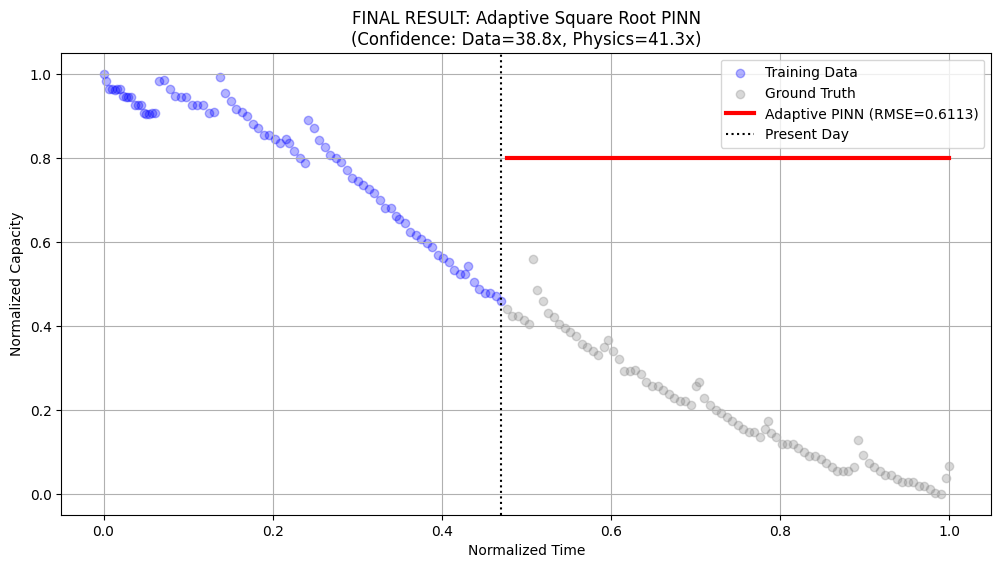

Final Adaptive RMSE: 0.6113


In [32]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Make Predictions
# The model is now fully trained with Adaptive Weights
C_pred_adaptive = pinn.predict(t_test_tf)

# 2. Calculate RMSE
rmse = np.sqrt(np.mean((c_test_tf.numpy() - C_pred_adaptive)**2))

# 3. Plot the Grand Result
plt.figure(figsize=(12, 6))

# Plot Training Data (What the model saw)
plt.scatter(t_train_tf, c_train_tf, color='blue', alpha=0.3, label='Training Data')

# Plot Test Data (What the model is guessing)
plt.scatter(t_test_tf, c_test_tf, color='gray', alpha=0.3, label='Ground Truth')

# Plot The Prediction
plt.plot(t_test_tf, C_pred_adaptive, 'r-', linewidth=3, label=f'Adaptive PINN (RMSE={rmse:.4f})')

# Formatting
plt.axvline(x=t_train_tf[-1], color='black', linestyle=':', label='Present Day')
plt.title(f'FINAL RESULT: Adaptive Square Root PINN\n(Confidence: Data={tf.exp(-pinn.log_vars[0]).numpy():.1f}x, Physics={tf.exp(-pinn.log_vars[1]).numpy():.1f}x)')
plt.xlabel('Normalized Time')
plt.ylabel('Normalized Capacity')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Adaptive RMSE: {rmse:.4f}")

Phase 2: Starting Adaptive Physics Training...
   -> Optimization: Found 2 Physics Vars and 8 Network Vars.
Epoch 0: Loss=2979.3579 | Alpha=0.9900
   -> Weights: Data=1.0 | Phys=1.0
Epoch 500: Loss=0.9734 | Alpha=0.0000
   -> Weights: Data=0.7 | Phys=0.5
Epoch 1000: Loss=-0.0927 | Alpha=-0.0000
   -> Weights: Data=2.1 | Phys=0.5
Epoch 1500: Loss=-1.3786 | Alpha=-0.0000
   -> Weights: Data=8.9 | Phys=0.6
Epoch 2000: Loss=-2.0684 | Alpha=0.0000
   -> Weights: Data=28.7 | Phys=0.6
Epoch 2500: Loss=-2.1506 | Alpha=-0.0000
   -> Weights: Data=38.1 | Phys=0.6
Training Complete.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


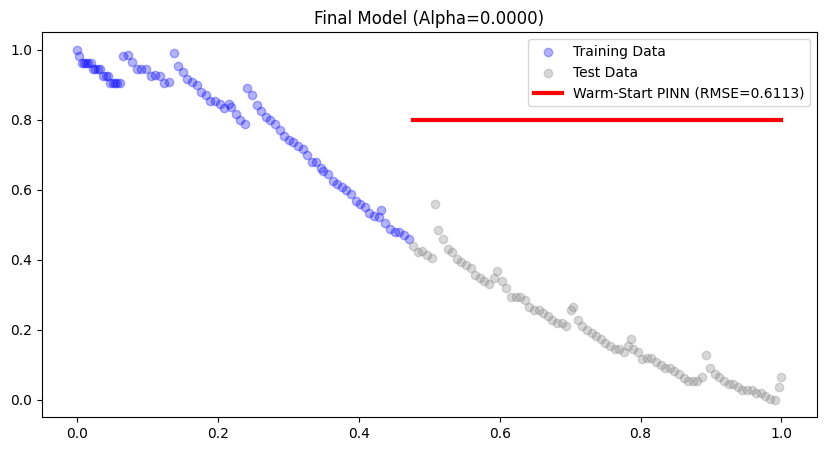

Final RMSE: 0.6113


In [34]:
# ==========================================
# PHASE 2: ADAPTIVE TRAINING (The Fix)
# ==========================================
print("Phase 2: Starting Adaptive Physics Training...")

# 1. ROBUST VARIABLE SPLITTING (Using 'is' to avoid the crash)
physics_vars = [pinn.alpha, pinn.log_vars]
network_vars = []

for v in pinn.trainable_variables:
    # Check if this variable is one of our physics variables
    is_physics_var = False
    for p in physics_vars:
        if v is p:
            is_physics_var = True
            break

    # If it's NOT a physics variable, it belongs to the network
    if not is_physics_var:
        network_vars.append(v)

print(f"   -> Optimization: Found {len(physics_vars)} Physics Vars and {len(network_vars)} Network Vars.")

# 2. TRAINING LOOP
# We need to re-initialize the fast optimizer for this phase
opt_params = tf.keras.optimizers.Adam(learning_rate=0.01)

for epoch in range(3000):

    # Persistent Tape for Dual Gradients
    with tf.GradientTape(persistent=True) as tape:
        c_pred = pinn(t_train_tf)
        loss_data = tf.reduce_mean(tf.square(c_pred - c_train_tf))
        loss_physics = pinn.physics_loss(t_train_tf)

        w_data = tf.exp(-pinn.log_vars[0])
        w_phys = tf.exp(-pinn.log_vars[1])

        total_loss = (w_data * loss_data + pinn.log_vars[0]) + (w_phys * loss_physics + pinn.log_vars[1])

    # Compute Gradients
    grads_physics = tape.gradient(total_loss, physics_vars)
    grads_network = tape.gradient(total_loss, network_vars)

    del tape # Free memory!

    # Update
    if len(grads_physics) > 0:
        opt_params.apply_gradients(zip(grads_physics, physics_vars))

    if len(grads_network) > 0:
        opt_network.apply_gradients(zip(grads_network, network_vars))

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss={total_loss.numpy():.4f} | Alpha={pinn.alpha.numpy():.4f}")
        print(f"   -> Weights: Data={tf.exp(-pinn.log_vars[0]).numpy():.1f} | Phys={tf.exp(-pinn.log_vars[1]).numpy():.1f}")

print("Training Complete.")

# ==========================================
# 3. FINAL PLOT
# ==========================================
C_pred = pinn.predict(t_test_tf)
rmse = np.sqrt(np.mean((c_test_tf.numpy() - C_pred)**2))

plt.figure(figsize=(10, 5))
plt.scatter(t_train_tf, c_train_tf, color='blue', alpha=0.3, label='Training Data')
plt.scatter(t_test_tf, c_test_tf, color='gray', alpha=0.3, label='Test Data')
plt.plot(t_test_tf, C_pred, 'r-', linewidth=3, label=f'Warm-Start PINN (RMSE={rmse:.4f})')
plt.title(f"Final Model (Alpha={pinn.alpha.numpy():.4f})")
plt.legend()
plt.show()

print(f"Final RMSE: {rmse:.4f}")